# GraphRAG说明


## Baseline RAG 系统在全局理解上的缺陷，例如：

- Baseline RAG 系统在面对需要从多源信息中抽取并综合分析的情况时，会遭遇显著的障碍。具体来说，当回答一个复杂问题涉及到通过识别和利用不同信息片段之间的共享属性，来构建新的、综合性见解时，Baseline RAG 无法有效连接这些“点”，导致信息整合上的不足。
- 在要求 Baseline RAG 对大规模的数据集合或是单篇幅巨大的文档进行全面而深入的理解时，它的表现会显得较为逊色。这通常是因为它在处理大量数据时，难以有效地捕捉和理解那些被浓缩于其中的关键语义概念，从而影响了整体的理解质量。

## GraphRAG介绍
### Index过程
GraphRAG 系统的索引分为三个阶段 数据预处理、从文本构建图数据 和 从图数据构建社区结构

- 阶段一：数据预处理
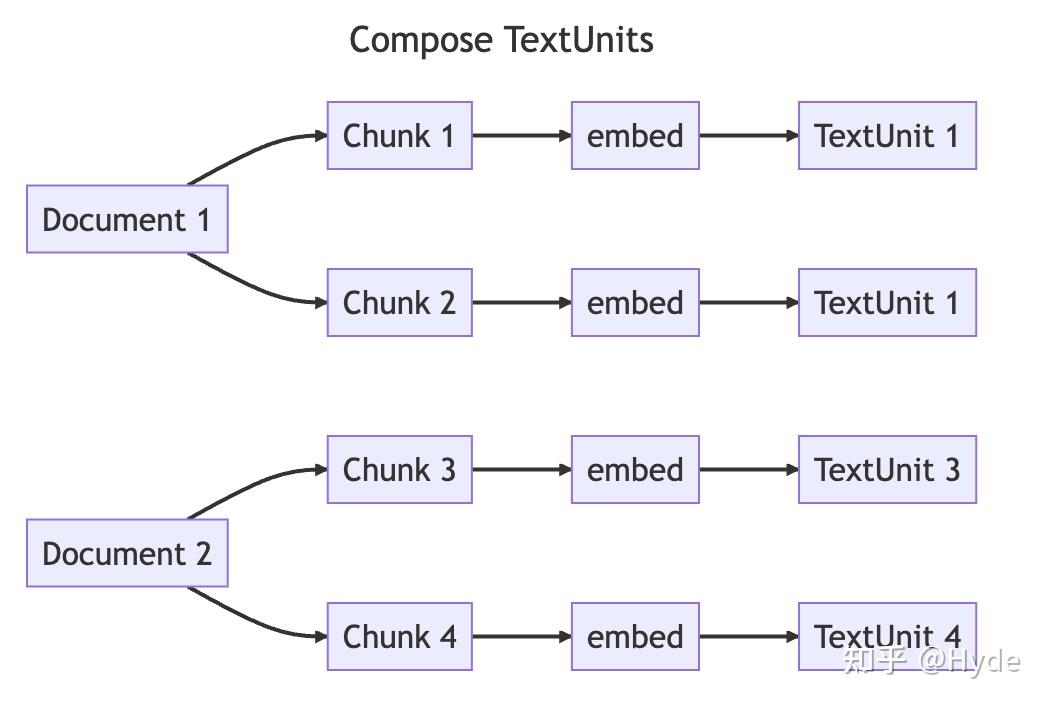
    - 在开始构图数据前，GraphRAG 系统需要对原始数据进行一系列预处理，即切块和文本嵌入。
    - 在预处理过程中，Chunk 大小是一个比较重要的参数。由于预处理后的文本单元（TextUnit）将在后续环节中提取图数据，使用较小的 Chunk 可以带来更高的保真度，但也会拖慢处理速度。
   
- 阶段二：构建图结构
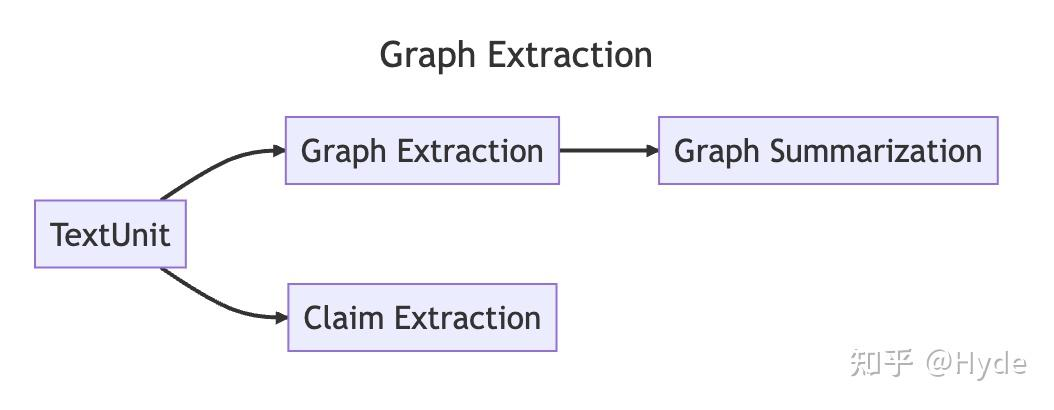
1. 图元素抽取

在这个阶段，GraphRAG 将驱动大模型对每个文本单元进行分析，从中抽取我们的图基础元素：实体、关系和主张（Entities, Relationships, Claims）。实体与关系通过我们的“Graph Extraction”操作一次性完成提取，而主张则通过“Graph Extraction”操作来获取。

        - Entities（实体） ：实体指的是现实世界中的具体事物或者概念，它们可以是人、地点、组织、事件、抽象概念等。例如，在句子“奥巴马出生于夏威夷。”中，“奥巴马”和“夏威夷”是实体。在 GraphRAG 中一个 Entity 包含了实体名称、实体类型和实体描述。
        - Relationships（关系） ：关系描述了实体之间的联系。例如，在上述句子中，“出生于”就是一种关系，它连接了实体“奥巴马”和“夏威夷”。在 GraphRAG 中一个 Relationships 包含了关系两端的实体名称和关系描述。
        - Claims（主张） ：主张通常指的是关于实体及其关系的陈述，它包含了一个或多个实体和关系的信息。例如：“奥巴马是美国第44任总统”，就是关于实体“奥巴马”的一个声明
2. 图元素总结

在抽取过程中，不同的 TextUnit 可能包含了关于同一实体的不同描述。例如随着小说《活着》的剧情发展，福贵会经历不同的事件。因此一个实体可能存在多个不同的描述。种情况下，我们不仅需要识别和提取实体，还要整合关于同一实体的多方面信息，确保我们的实体描述尽可能完整和准确。

在 Graph Summarization 过程中，GraphRAG 将驱动 LLM 将描述列表转化为一个简短的摘要，并确保每个实体和关系都有且仅有一段简洁的的描述信息。
- 阶段三：构建社区结构


1. 构建社区结构

为了获得对数据的整体性理解，GraphRAG 递归地使用莱顿算法对知识图谱进行聚类，并产生不同层次的社区（Community）结构。

Community 结构是指在一个更大的网络中，节点（如 GraphRAG 中的实体）倾向于形成密集的局部集群，这些集群被称为 Community。Community 内部的节点之间有较多的边（联系），而 Community 之间的边则相对较少。换句话说，Community 结构体现了网络中节点的聚类特性，这些节点基于某种相似性或功能上的关联性而聚集在一起。

2. 图嵌入

GraphRAG 使用 Node2Vec 算法生成图的矢量表示。这将使系统能够理解图的隐式结构，并提供一个额外的向量空间，以便在查询阶段搜索相关概念。

3. 生成社区报告/摘要

在此阶段，GraphRAG 会为不同层级的社区建立报告（Report），而这些报告代表了对原始数据不同层次的理解。形象来说，这些社区构成了一个树状结构，更接近根的社区报告通常覆盖了更大的范围，代表了更加全局和概括性的理解。而越接近枝叶的社区通常覆盖面越窄，理解也越微观。

此外，这种报告也可以作为理解数据全局结构的一种方式，可以通过摘要找到有用的社区，然后下钻到包含更详细信息的子社区中。

4. 社区嵌入

最后，我们为此阶段创建的内容执行文本嵌入，以便于在查询阶段搜索相关内容。

由此我们就完成了 GraphRAG 中索引的过程。

### Query过程
GraphRAG 提供了两种不同的查询模式。

Global Query 用于回答更加全局性的问题，例如“小说《活着》的主题是什么”，而 Local Query 则用于回答更加具体的问题

1. 全局检索

具体而言，Global Query 的过程如图所示：


Global Query 方法使用从社区层次结构指定层级中收集的报告作为上下文数据，以类似Map - Reduce的方式生成响应。在 Map 步骤中，社区报告被分割成文本块，每个文本块用于生成中间响应，其中每个点都有一个数值评级。在 Reduce 步骤中，从中间响应中挑选出最重要的点并进行聚合，最终形成用于生成最终响应的上下文。

这种方法的直观理解是：越宏观的问题需要越宏观的视角和信息来回答。

社区层次结构中的每一层代表着不同粒度的信息集合。高层级可能包含更为概括和宏观的观点，而低层级则提供具体和细节化的信息。对于宏观问题，系统倾向于选择较高层级的数据，以捕捉整体趋势和主要观点。

通过 Map - Reduce 过程，系统可以选择对于原始问题的重要性或相关性较高的信息，并进一步提炼和汇总，形成一个精炼的、综合的上下文。这个上下文包含了对原始问题最相关的见解和数据，是生成最终响应的基础。

2. 局部检索

本地查询则基于更加微观的视角，结合知识图谱中的结构化数据与原始文档中的非结构化数据，来增强检索和生成过程中的上下文。因此，Local Query 别适合回答那些需要理解输入文档中特定实体的问题，比如询问“洋甘菊有哪些治疗特性？”这样的问题。

具体而言，Local Query 的过程如图所示：


首先，系统将依据原始提问，从知识图谱中识别出一组与用户输入语义相关的实体。

然后，利用这些实体作为查询条件，在知识图谱或相关数据库中进行检索，找到与这些实体直接相关的内容，包含：TextUnit、社区报告、实体、关系或协变量（如主张）。

检索的结果经过过滤和重排序后，选择高质量的数据源，并将其整合进一个预定义大小的上下文窗口。这个窗口内的信息用于构建响应，确保回答内容既精确又详尽。

### 那么代价是什么呢？
虽然 Graph 带来了更优秀的效果，但由于索引过程完全使用 LLM 来完成，这将带来巨大的 Token 开销，耗时也非常久。

例如，我尝试对 12 万字的小说进行索引时产生了数百万 Token 的调用量。这远比构建索引仅需调用 embedding 模型的传统 RAG 系统昂贵得多。

而在 Query 阶段，一次响应的耗时与 Token 用量也非常大。例如，在一次 Global Query 中，响应耗时接近 1 分钟，且消耗了 65083 个 Token。

In [13]:
!pip install graphrag

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.6/80.6 kB 325.8 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 794.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 798.0 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 2.2 MB/s eta 0:00:00


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.9/112.9 kB 2.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 14.3 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.3/406.3 kB 2.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 3.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.3/491.3 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 44.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.4/25.4 MB 32.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.0 MB/s eta 0:

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.9/106.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 38.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 28.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 47.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 5.8 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 8.5.0
    Uninstalling tenacity-8.5.0:
      Successfully uninstalled tenacity-8.5.0
  Attempting uninstal

创建 GraphRAG 目录，并将数据样本存放于项目目录下的 input 文件夹内.

In [3]:
mkdir -p ./ragtest/input

初始化 graphrag 项目

In [1]:
!graphrag init --root ./ragtest


Initializing project at 
/Users/houhailun/Desktop/code/notebook/llm/GraphRAG/ragtest
⠋ GraphRAG Indexer ╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/graphrag/ │
│ cli/main.py:105 in _initialize_cli                                           │
│                                                                              │
│   102 │   """Generate a default configuration file."""                       │
│   103 │   from graphrag.cli.initialize import initialize_project_at          │
│   104 │                                                                      │
│ ❱ 105 │   initialize_project_at(path=root)                                   │
│   106                                                                        │
│   107                                                                        │
│   108 @app.command("index")                                                  │
│    

In [2]:
# 为了使用 ZhipuAI 的模型替代 OpenAI 的模型，需要修改一些参数。
# 修改点
# 1.在.env文件中配置api、-key
# 2.在ragtest/setting.yarm中修改LLM和embeddings
#    修改LLM/embeddimgs下的model和api_base

In [8]:
# 创建索引
# !curl https://www.gutenberg.org/cache/epub/24022/pg24022.txt -o ./ragtest/input/book.txt
    
!graphrag index --root ./ragtest


Logging enabled at r 
/Users/houhailun/Desktop/code/notebook/llm/GraphRAG/ragtest/logs/indexing-engine
.log
⠋ GraphRAG Indexer 
⠋ GraphRAG Indexer les loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠇ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
🚀 create_base_text_units
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
Empty DataFrame
Columns: []
Index: []
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
🚀 create_final_documents
⠋ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…


⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
🚀 create_final_communities
⠏ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
                                      id  human_readable_id  ...      period  
size
0   eb389cef-c1de-4cf2-bd2c-c2f54c26c7c6                  0  ...  2024-12-21    
11
1   9f62f118-8a40-436e-84bb-128a50bed8af                  2  ...  2024-12-21    
7
2   599e3c78-de86-4590-8f1a-3643db8d0088      

⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
⠹ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
├── create_final_relationships
🚀 create_final_text_units
⠸ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
├── create_final_relationships
                                  id  ...                                   
relationship_ids
0   469e49f1710e3fd32bd53e9d764f

⠧ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
├── create_final_relationships
├── create_final_text_units
⠧ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
├── create_final_relationships
├── create_final_text_units
⠧ GraphRAG Indexer 
├── Loading Input (text) - 1 files loaded (1 filtered) ━━━━━━ 100% 0:00:… 0:00:…
├── create_base_text_units
├── create_final_documents
├── create_base_entity_graph
├── create_final_entities
├── create_final_nodes
├── create_final_communities
├── create_final_relationships
├── create_final_text_units
├── create_final_community_reports
⠼ 

使用中文文档，在 generate_text_embeddings
时报错：{
    "type": "error",
    "data": "Error executing verb \"generate_text_embeddings\" in generate_text_embeddings: Length of values (18) does not match length of index (20)",
    "stack": "Traceback (most recent call last):\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/datashaper/workflow/workflow.py\", line 415, in _execute_verb\n    result = await result\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/graphrag/index/workflows/v1/subflows/generate_text_embeddings.py\", line 56, in generate_text_embeddings\n    await generate_text_embeddings_flow(\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/graphrag/index/flows/generate_text_embeddings.py\", line 100, in generate_text_embeddings\n    await _run_and_snapshot_embeddings(\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/graphrag/index/flows/generate_text_embeddings.py\", line 123, in _run_and_snapshot_embeddings\n    data[\"embedding\"] = await embed_text(\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/pandas/core/frame.py\", line 4311, in __setitem__\n    self._set_item(key, value)\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/pandas/core/frame.py\", line 4524, in _set_item\n    value, refs = self._sanitize_column(value)\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/pandas/core/frame.py\", line 5266, in _sanitize_column\n    com.require_length_match(value, self.index)\n  File \"/Users/houhailun/anaconda3/envs/torch/lib/python3.10/site-packages/pandas/core/common.py\", line 573, in require_length_match\n    raise ValueError(\nValueError: Length of values (18) does not match length of index (20)\n",
    "source": "Length of values (18) does not match length of index (20)",
    "details": null
}

-----
尝试使用官网给出的英文，同样失败

-----
尝试把chunk从1200降低为300，同样失败

-----
通过编辑 graphrag\index\operations\embed_text\embed_text.py 解决了这个问题。在第 187 行中，不应过滤那些嵌入为 None。
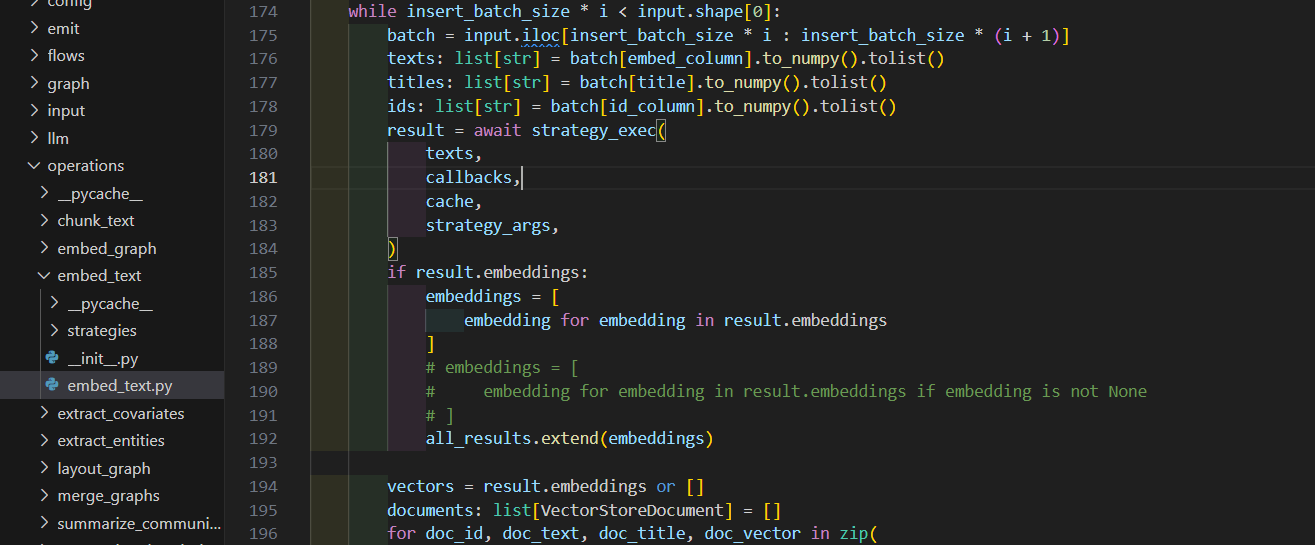

构建查询

In [11]:
!graphrag query --root ./ragtest --method global --query "What are the top themes in this story?"



creating llm client with {'api_key': 'REDACTED,len=36', 'type': "openai_chat", 'model': 'ep-20241010102617-dc2hr', 'max_tokens': 4000, 'temperature': 0.0, 'top_p': 1.0, 'n': 1, 'request_timeout': 180.0, 'api_base': 'https://ark.cn-beijing.volces.com/api/v3', 'api_version': None, 'organization': None, 'proxy': None, 'audience': None, 'deployment_name': None, 'model_supports_json': False, 'tokens_per_minute': 0, 'requests_per_minute': 0, 'max_retries': 10, 'max_retry_wait': 10.0, 'sleep_on_rate_limit_recommendation': True, 'concurrent_requests': 25}

SUCCESS: Global Search Response:
The top themes in this story are as follows:

**1. The Character of Scrooge and His Relationships**
Scrooge is central in many communities. His relationships are diverse, including his business partnership with Marley [Data: Reports (18, 23, 21, 17, 13, 10, 22, 14, 24)]. He also has family relations, like with his nephew, and interactions with other entities such as his clerk and the ghosts. This theme is h